In [1]:
%matplotlib inline
from pyvista import set_plot_theme
set_plot_theme('document')


# Create SHEMAT-Suite models
 
 With the MC ensemble of generated geological models stored in the respective lith-blocks, we can use them to create SHEMAT-Suite models for then doing 
 forward simulations of Heat- and Mass-transfer.


Libraries



In [2]:
import os,sys
sys.path.append('../../')
import OpenWF.shemat_preprocessing as shemsuite
import glob
import numpy as np
import itertools as it
import gempy as gp
import pandas as pd
import matplotlib.pyplot as plt

print(f"Run with GemPy version {gp.__version__}")

Run with GemPy version 2.2.9


## load the base model
For creating SHEMAT-Suite input files from the Monte Carlo Ensemble we created in `sphx_glr_examples_geo_modeling_02_POC_create-MC-ensemble.py` we load the base POC model, which was created
in `sphx_glr_examples_geo_modeling_01_POC_generate-model.py`. As we want to have the topography also in the SHEMAT-Suite model later on, we will create a mask of the model topography, called
`topo_mask`



In [3]:
model_path = '../../models/2021-06-04_POC_base_model'
geo_model = gp.load_model('POC_PCT_model',
                         path=model_path, recompile=False)
topo = geo_model._grid.topography.values.shape
topo_mask = geo_model._grid.regular_grid.mask_topo
dtm = np.load(model_path+'/POC_PCT_model_topography.npy')

Active grids: ['regular']
Active grids: ['regular' 'topography']


## Load the MC-lithologies
Next, we load the lithology blocks created by the MC example and mask them by the topography



In [4]:
lith_blocks = np.load('../../data/outputs/MCexample_10realizations.npy')

lith_blocks_topo = np.array([])
for i in lith_blocks:
    lith_blocks_topo = np.append(lith_blocks_topo, shemsuite.topomask(geo_model, i))
lith_blocks_topo = lith_blocks_topo.reshape(len(lith_blocks), -1)

The model topography is not only important for the geological model, i.e. cutting geology with topography to produce a geological map, but is also vital for later on heat transport simulations.
Especially if a simulation should consider advective/convective heat transport, as these can be driven by the topography. Similarly, surface temperature correlates with altitute. 
Hence, knowing topography is important, when we want to have a realistic top boundary condition for temperature in a model which includes topography. Usually, surface temperature is available from 
meteorologic services. If, however, that is not the case, surface temperature as a function of altitude can be estimated from an average lapse rate $L$ (0.0065 K/m) and knowledge of temperature at 
sea level. 



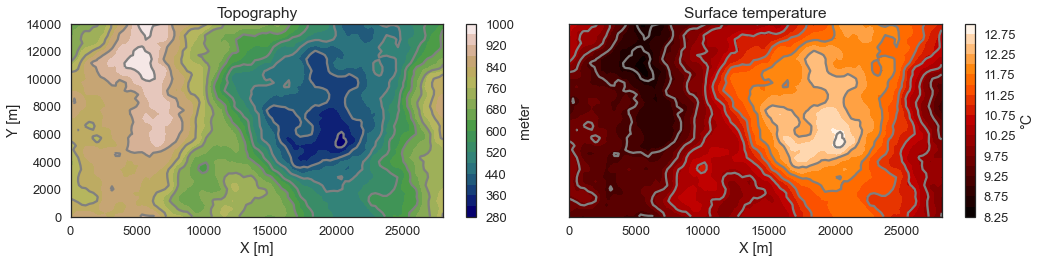

In [5]:
# calculate surface temperatures
sea_temp = 288 # in Kelvin
L = 0.0065 # in Kelvin per metre
surf_temp = (sea_temp - L * dtm[:,:,2]) - 273.15

# create figure
fig, axs = plt.subplots(1,2, figsize=[15,4], sharey=True)

m = axs[0].contourf(dtm[:,:,0], dtm[:,:,1], dtm[:,:,2],20, cmap='gist_earth', zorder=0)
axs[0].contour(dtm[:,:,0], dtm[:,:,1], dtm[:,:,2],10, colors='gray', zorder=1)

s = axs[1].contourf(dtm[:,:,0], dtm[:,:,1], surf_temp,20, cmap='gist_heat', zorder=0)
axs[1].contour(dtm[:,:,0], dtm[:,:,1], dtm[:,:,2],10, colors='gray', zorder=1)
fig.colorbar(m, ax=axs[0], label='meter')
fig.colorbar(s, ax=axs[1], label='°C')
axs[0].set_title('Topography')
axs[1].set_title('Surface temperature')
axs[0].set_ylabel('Y [m]')
axs[0].set_xlabel('X [m]')
axs[1].set_xlabel('X [m]')


fig.tight_layout()

Now we prepared the lithologies, which are necessary for the `# uindex` field in a SHEMA-Suite input file, we can prepare the other parameters. Of which some are necessary, like the model
dimensions, and some are optional, like an array for the hydraulic head boundary condition, or observed data.



In [6]:
xmin, xmax, ymin, ymax, zmin, zmax = geo_model.grid.regular_grid.extent
temp_data = '../../data/SHEMAT-Suite/all_boreholes_as_shemat_data.csv'

## Create Top Boundary Conditions for head and temperature

First we load the lithology grid of the base model and make sure, the lithology IDs are all integers. To know where we would have air cells, we mask the lithology grid with the model topology. Now, the air has its own unit, which is per default the maximum lithology ID + 1.

In [44]:
lith_grid = np.load('../../models/POC_base_model_lith_blocks.npy')

# make sure that lithologies are integer
lith_grid = np.round(lith_grid,0).astype('int')

In [90]:
lith_grid_topo = shemsuite.topomask(geo_model, lith_grid)

In [49]:
res = geo_model._grid.regular_grid.resolution

In [91]:
liths3D = lith_grid_topo.reshape((res), order='C')

In [93]:
ijk = np.where(liths3D[:,:,:]==13)

In [128]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
9,Thrust1_south,Thrust1_series,1,#5DA629,1
10,Thrust2_south,Thrust2_series,1,#5DA629,2
0,Fault2,Fault2_series,1,#015482,3
1,Fault5,Fault5_series,1,#015482,4
2,Fault6,Fault6_series,1,#015482,5
6,Tertiary,Post_tectonic_series,1,#dbdbac,6
8,Pink,Post_tectonic_series,2,#e588f3,7
7,Orange,Post_tectonic_series,3,#ff792b,8
5,Unconformity,Detachement,1,#725c9a,9
4,Upper-filling,Syn_tectonic_series2,1,#cfc199,10


In [94]:
s = np.stack([ijk[0], ijk[1], ijk[2]], axis=1)

In [145]:
ijk

(array([ 0,  0,  0, ..., 99, 99, 99], dtype=int64),
 array([ 0,  1,  2, ..., 49, 49, 49], dtype=int64),
 array([59, 59, 58, ..., 57, 58, 59], dtype=int64))

In [95]:
s1 = s.copy()
s1[:,2] = s1[:,2] - 1

In [127]:
s1.shape

(13652, 3)

In [157]:
s2 = np.append(s, s1, axis=0) 
s2 = np.unique(s2, axis=0)

In [158]:
s2.shape

(18527, 3)

In [159]:
new_array = [tuple(row) for row in s2]
s3 = np.unique(new_array, axis=0)

In [170]:
s3.shape

(18527, 3)

In [160]:
zs = dtm[:,:,2]

In [164]:
height = np.zeros(len(s3))
temp_bc = np.zeros(len(s3))

for i in range(len(s3)):
    indices = s3[i,:2]
    height[i] = zs[indices[0], indices[1]]
    temp_bc[i] = surf_temp[indices[0], indices[1]]

In [165]:
hresh = height.reshape(-1,1)
tbc_resh = temp_bc.reshape(-1,1)
ijkh = np.append(s3, hresh, axis=1)
ijkt = np.append(s3, tbc_resh, axis=1)

In [166]:
ijkh[:,:3] = ijkh[:,:3] + 1
ijkt[:,:3] = ijkt[:,:3] + 1
ijkh[:,3] = ijkh[:,3] + 6500

In [167]:
direction = np.zeros_like(hresh)

In [168]:
ijkh_d = np.append(ijkh, direction, axis=1)
ijkt_d = np.append(ijkh, direction, axis=1)

In [169]:
np.savetxt('../../data/SHEMAT-Suite/head_bcd.txt', ijkh_d, fmt='%d, %d, %d, %.3f, %d')
np.savetxt('../../data/SHEMAT-Suite/temp_bcd.txt', ijkt_d, fmt='%d, %d, %d, %.3f, %d')

## Set up the units for the SHEMAT-Suite model
One core element of a SHEMAT-Suite Input file is the `# units` table. This table comprises the petrophysical parameters of the lithological units whose geometry is stored in the `# uindex` field.
The following code shows an example of how set up the `# units` table as a dataframe to be then stored in a SHEMAT-Suite input file. 



In [7]:
# Load existing units of the geological model:
units = geo_model.surfaces.df[['surface', 'id']]
units

,surface,id
9,Thrust1_south,1
10,Thrust2_south,2
0,Fault2,3
1,Fault5,4
2,Fault6,5
6,Tertiary,6
8,Pink,7
7,Orange,8
5,Unconformity,9
4,Upper-filling,10


Now we create a dictionary with values for important parameters of each of the 12 units:
And join it with the existing units dataframe.



In [8]:
params = {'por': np.array([1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 0.1, 0.05, 0.05, 0.01, 0.1, 0.05, 0.01]).T,
         'perm': np.array([1e-16, 1e-16, 1e-16, 1e-16, 1e-16, 1.0e-14, 1.0e-14, 1.0e-15, 1.0e-17, 1.0e-14, 1.0e-15, 1.0e-16]),
         'lz':   np.array([2.5, 2.5, 2.5, 2.5, 2.5, 2.3, 1.93, 2.9, 4.64, 2.03, 3.21, 3.1])}

units = units.join(pd.DataFrame(params, index=units.index))

So now, the `units` table looks like this:



In [9]:
units

,surface,id,por,perm,lz
9,Thrust1_south,1,1.000000e-10,1.000000e-16,2.50
10,Thrust2_south,2,1.000000e-10,1.000000e-16,2.50
0,Fault2,3,1.000000e-10,1.000000e-16,2.50
1,Fault5,4,1.000000e-10,1.000000e-16,2.50
2,Fault6,5,1.000000e-10,1.000000e-16,2.50
6,Tertiary,6,1.000000e-01,1.000000e-14,2.30
8,Pink,7,5.000000e-02,1.000000e-14,1.93
7,Orange,8,5.000000e-02,1.000000e-15,2.90
5,Unconformity,9,1.000000e-02,1.000000e-17,4.64
4,Upper-filling,10,1.000000e-01,1.000000e-14,2.03


It is still missing the air component though. We have to add this, because the cells above the topography are
assigned to a unit representing the air. For mimicking the long-wavelength radiation outward from the ground, we assign
a high thermal conductivity to the air. If we were to assign a realistic low thermal conductivity, it would work as an insulator.



In [10]:
air = {'surface': 'air',
       'id': units.shape[0]+1,
      'por': 1e-10,
      'perm': 1e-22,
      'lz': 100}
units = units.append(air, ignore_index=True)

## Export to SHEMAT-Suite
We are now all set for combining the lithology arrays, the `# units` table, temperature data from boreholes
into a SHEMAT-Suite input file. For this, we use the method `export_shemat_suite_input_file` in 
OpenWF.shemat_preprocessing.



In [11]:
shemade = ""
for c in range(len(lith_blocks_topo)):
    model = lith_blocks_topo[c,:]
    model_name = f"POC_MC_{c}"
    shemsuite.export_shemat_suite_input_file(geo_model, lithology_block=model, units=units,  
                                   data_file=temp_data, head_bcs_file='../../data/SHEMAT-Suite/head_bcd.txt',
                                   top_temp_bcs_file='../../data/SHEMAT-Suite/temp_bcd.txt',
                                   path='../../models/SHEMAT-Suite_input/',
                                  filename=model_name)
    shemade += model_name + " \n"
with open("../../models/SHEMAT-Suite_input/shemade.job", 'w') as jobfile:
    jobfile.write(shemade)

Successfully exported geological model POC_MC_0 as SHEMAT-Suite input to ../../models/SHEMAT-Suite_input/
Successfully exported geological model POC_MC_1 as SHEMAT-Suite input to ../../models/SHEMAT-Suite_input/
Successfully exported geological model POC_MC_2 as SHEMAT-Suite input to ../../models/SHEMAT-Suite_input/
Successfully exported geological model POC_MC_3 as SHEMAT-Suite input to ../../models/SHEMAT-Suite_input/
Successfully exported geological model POC_MC_4 as SHEMAT-Suite input to ../../models/SHEMAT-Suite_input/
Successfully exported geological model POC_MC_5 as SHEMAT-Suite input to ../../models/SHEMAT-Suite_input/
Successfully exported geological model POC_MC_6 as SHEMAT-Suite input to ../../models/SHEMAT-Suite_input/
Successfully exported geological model POC_MC_7 as SHEMAT-Suite input to ../../models/SHEMAT-Suite_input/
Successfully exported geological model POC_MC_8 as SHEMAT-Suite input to ../../models/SHEMAT-Suite_input/
Successfully exported geological model POC_MC_